In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import datetime
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [84]:
from prophet import Prophet

In [114]:
from datetime import datetime
from datetime import timedelta

import plotly.graph_objects as go
import plotly.express as px

from metrics import rmse, rmsep,  rmspe
from plot_methods import *


In [2]:
train = pd.read_csv("data/train.csv", 
                    parse_dates = True, low_memory = False)

store = pd.read_csv("data/store.csv", 
                    parse_dates = True, low_memory = False)

In [44]:
print("Joining train set with an additional store information.")
# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

Joining train set with an additional store information.


In [45]:
train_store = train_store.drop(columns=['Open','Promo','StateHoliday', 'Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'])

In [46]:
train_store

,Store,DayOfWeek,Date,Sales,Customers,SchoolHoliday,StoreType
0,1,5,2015-07-31,5263,555,1,c
1,1,4,2015-07-30,5020,546,1,c
2,1,3,2015-07-29,4782,523,1,c
3,1,2,2015-07-28,5011,560,1,c
4,1,1,2015-07-27,6102,612,1,c
...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,d
1017205,1115,5,2013-01-04,4540,326,1,d
1017206,1115,4,2013-01-03,4297,300,1,d
1017207,1115,3,2013-01-02,3697,305,1,d


In [47]:
fixed_price = {'itemA': 10.05, 'itemB': 80.01, 'itemC': 5.78, 'itemD': 23.05, 'itemE': 36.98}

In [48]:
fixed_price
values =fixed_price.values() 
sum_ = sum(values)

In [49]:
fixed_price.items()


dict_items([('itemA', 10.05), ('itemB', 80.01), ('itemC', 5.78), ('itemD', 23.05), ('itemE', 36.98)])

In [50]:
new = {k : v/sum_ for k,v in fixed_price.items()}

In [51]:
train_store['sales_PA'] = train_store['Sales']/5
train_store['sales_PB'] = train_store['Sales']/5
train_store['sales_PC'] = train_store['Sales']/5
train_store['sales_PD'] = train_store['Sales']/5
train_store['sales_PE'] = train_store['Sales']/5

In [52]:
train_store

,Store,DayOfWeek,Date,Sales,Customers,SchoolHoliday,StoreType,sales_PA,sales_PB,sales_PC,sales_PD,sales_PE
0,1,5,2015-07-31,5263,555,1,c,1052.6,1052.6,1052.6,1052.6,1052.6
1,1,4,2015-07-30,5020,546,1,c,1004.0,1004.0,1004.0,1004.0,1004.0
2,1,3,2015-07-29,4782,523,1,c,956.4,956.4,956.4,956.4,956.4
3,1,2,2015-07-28,5011,560,1,c,1002.2,1002.2,1002.2,1002.2,1002.2
4,1,1,2015-07-27,6102,612,1,c,1220.4,1220.4,1220.4,1220.4,1220.4
...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,d,954.2,954.2,954.2,954.2,954.2
1017205,1115,5,2013-01-04,4540,326,1,d,908.0,908.0,908.0,908.0,908.0
1017206,1115,4,2013-01-03,4297,300,1,d,859.4,859.4,859.4,859.4,859.4
1017207,1115,3,2013-01-02,3697,305,1,d,739.4,739.4,739.4,739.4,739.4


In [53]:
train_store['n_itemsA'] = train_store['sales_PA']/10.05
train_store['n_itemsB'] = train_store['sales_PB']/80.01
train_store['n_itemsC'] = train_store['sales_PC']/5.78
train_store['n_itemsD'] = train_store['sales_PD']/23.05
train_store['n_itemsE'] = train_store['sales_PE']/36.98

In [54]:
train_store

,Store,DayOfWeek,Date,Sales,Customers,SchoolHoliday,StoreType,sales_PA,sales_PB,sales_PC,sales_PD,sales_PE,n_itemsA,n_itemsB,n_itemsC,n_itemsD,n_itemsE
0,1,5,2015-07-31,5263,555,1,c,1052.6,1052.6,1052.6,1052.6,1052.6,104.736318,13.155856,182.110727,45.665944,28.464035
1,1,4,2015-07-30,5020,546,1,c,1004.0,1004.0,1004.0,1004.0,1004.0,99.900498,12.548431,173.702422,43.557484,27.149811
2,1,3,2015-07-29,4782,523,1,c,956.4,956.4,956.4,956.4,956.4,95.164179,11.953506,165.467128,41.492408,25.862628
3,1,2,2015-07-28,5011,560,1,c,1002.2,1002.2,1002.2,1002.2,1002.2,99.721393,12.525934,173.391003,43.479393,27.101136
4,1,1,2015-07-27,6102,612,1,c,1220.4,1220.4,1220.4,1220.4,1220.4,121.432836,15.253093,211.141869,52.945770,33.001622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,d,954.2,954.2,954.2,954.2,954.2,94.945274,11.926009,165.086505,41.396963,25.803137
1017205,1115,5,2013-01-04,4540,326,1,d,908.0,908.0,908.0,908.0,908.0,90.348259,11.348581,157.093426,39.392625,24.553813
1017206,1115,4,2013-01-03,4297,300,1,d,859.4,859.4,859.4,859.4,859.4,85.512438,10.741157,148.685121,37.284165,23.239589
1017207,1115,3,2013-01-02,3697,305,1,d,739.4,739.4,739.4,739.4,739.4,73.572139,9.241345,127.923875,32.078091,19.994592


In [55]:
train_store['total_items']= train_store['n_itemsA'] + train_store['n_itemsB'] + train_store['n_itemsC'] + train_store['n_itemsD'] + train_store['n_itemsE']

In [56]:
train_store['Date'] = pd.to_datetime(train_store['Date'])
train_store = train_store.set_index(train_store['Date'])

In [58]:
monthly_sold_items = train_store.resample('M').agg({'total_items':np.sum})

In [61]:
from datetime import datetime
from datetime import timedelta

In [62]:
one_year = timedelta(days=365)

In [63]:
monthly_sold_items['Year'] =  monthly_sold_items.index.year
monthly_sold_items['Month'] = monthly_sold_items.index.month
    
monthly_y2013 = monthly_sold_items[monthly_sold_items['Year']==2013]
monthly_y2014 = monthly_sold_items[monthly_sold_items['Year']==2014]
monthly_y2015 = monthly_sold_items[monthly_sold_items['Year']==2015]
    
shifted_2013_index =  monthly_y2013.index + pd.Timedelta(one_year) + pd.Timedelta(one_year)
shifted_2013       =  monthly_y2013.set_index(shifted_2013_index)     
shifted_2014_index =  monthly_y2014.index + pd.Timedelta(one_year)
shifted_2014       =  monthly_y2014.set_index(shifted_2014_index) 

In [64]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

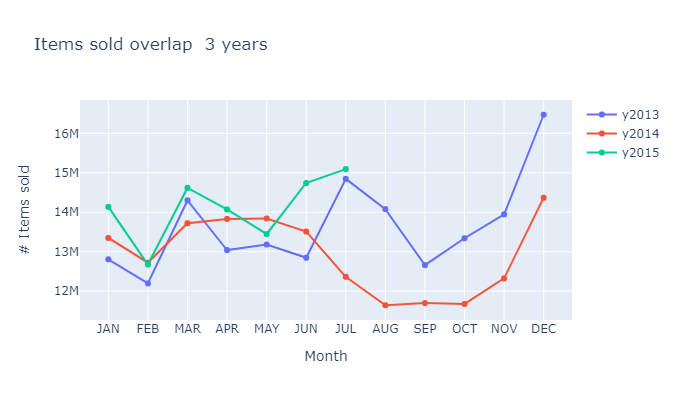

In [71]:
Months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP', 'OCT', 'NOV', 'DEC']
def plot_3years_items(df1,df2,df3):
    hover = "%{y:#,.2f}" 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = Months,    y = df1['total_items']  , name = "y2013",  hovertemplate="Month: %{x} <br>" + f"{'#items'}: {hover}" ))
    fig.add_trace(go.Scatter(x = Months,    y = df2['total_items']  , name = "y2014",  hovertemplate="Month: %{x} <br>" + f"{'#items'}: {hover}" ))
    fig.add_trace(go.Scatter(x = Months,    y = df3['total_items']  , name = "y2015",  hovertemplate="Month: %{x} <br>" + f"{'#items'}: {hover}" ))
    # fig.add_trace(go.Scatter(x =important_dates,
    #                      y = [0,0,0,0] , 
    #                      marker = {"color":["MidnightBlue", "IndianRed", "MediumPurple","Orange"], "line":{"width":1}, "size":8},
    #                      mode = "markers+text",
    #                      name = 'events',
    #                      #showlegend = False,
    #                      text = ocasion, 
    #                      textposition = "top center"))

    fig.update_layout(xaxis_title = "Month",
                  yaxis_title = '# Items sold',
                  title = "Items sold overlap  3 years",
                  height = 400,
                  hovermode = "x"   )

    fig.show()

plot_3years_items(shifted_2013,shifted_2014,monthly_y2015)

In [111]:
item = 'n_itemsE'

In [112]:
weekly_sold_items = train_store.resample('W-Fri').agg({item:np.sum})
weekly_sold_items['Date'] = weekly_sold_items.index
items = weekly_sold_items.rename(columns = {'Date': 'ds', item : 'y'})
items = items.fillna(0)

my_model = Prophet(interval_width = 0.75)
my_model.fit(items)
    
    # dataframe that extends into future 6 weeks 
    #future_dates = my_model.make_future_dataframe(periods = 6)
future_dates =  pd.DataFrame({'ds': pd.date_range('2013-01-01', '2015-09-25', freq='W-Fri')})
forecast = my_model.predict(future_dates)
    
print("Finished calculating Forecast " )

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.41594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       242.999   2.78409e-06       83.9841      0.4343      0.4343      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       243.003   1.34037e-05        90.485   1.314e-07       0.001      184  LS failed, Hessian reset 
     153       243.004   8.60475e-09        102.21      0.1723      0.1723      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Finished calculating Forecast 


Showing only one year of data


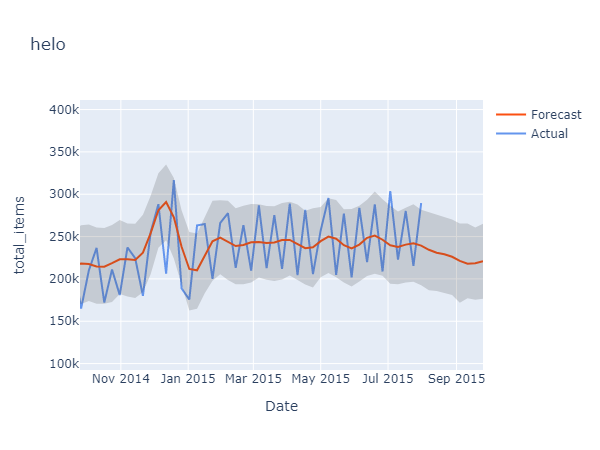

In [113]:
plot_individual_store_prediction(forecast, items, 0, 'total_items', " helo")

In [88]:
def time_interval(some_df):
    one_year = timedelta(days=365)
    last = len(some_df)

    last = some_df.ds.values[last-1]
    last = pd.to_datetime(last)

    start = last - one_year 
    
    return start, last

def plot_individual_store_prediction(df_forecast, df_sales, store, feature, title_):
    
    start, end = time_interval(df_forecast)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = df_sales['ds'],   y = df_sales['y']     , name = "Actual",   hovertemplate="Sales: %{y:$,.2f}" , mode = 'lines', line =dict(color="#6495ed")))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat  , name = "Forecast", hovertemplate="Sales: %{y:$,.2f}" , mode = 'lines', line =dict(color="#fb5012")))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat_upper , mode = 'lines', line = dict(width = 0), hoverinfo = "skip", showlegend = False, name = "Upper" ))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat_lower , mode = 'lines', line = dict(width = 0) , fillcolor= 'rgba(68,68,68, 0.2)', fill = "tonexty", hoverinfo = "skip", showlegend = False, name = "Upper" ))

    fig.update_layout(xaxis_title = "Date",
                      yaxis_title = feature,
                      #title = "Forecast: open on sundays - Store no. " + str(store),
                      height = 450,
                      title = title_,
                      hovermode = "x",
                      xaxis_range = [start, end]   )

    print("Showing only one year of data")

    return fig

In [90]:
itemsA= train_store[train_store['n_itemsA']==]
itemsA['Date'] = pd.to_datetime(stores_type_['Date'])
itemsA= itemsA.groupby('Date').sum()
itemsA =itemsA.resample('W-Fri').agg({'Sales':np.sum})

,Store,DayOfWeek,Date,Sales,Customers,SchoolHoliday,StoreType,sales_PA,sales_PB,sales_PC,sales_PD,sales_PE,n_itemsA,n_itemsB,n_itemsC,n_itemsD,n_itemsE,total_items
Date,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263,555,1,c,1052.6,1052.6,1052.6,1052.6,1052.6,104.736318,13.155856,182.110727,45.665944,28.464035,374.132879
2015-07-30,1,4,2015-07-30,5020,546,1,c,1004.0,1004.0,1004.0,1004.0,1004.0,99.900498,12.548431,173.702422,43.557484,27.149811,356.858646
2015-07-29,1,3,2015-07-29,4782,523,1,c,956.4,956.4,956.4,956.4,956.4,95.164179,11.953506,165.467128,41.492408,25.862628,339.939849
2015-07-28,1,2,2015-07-28,5011,560,1,c,1002.2,1002.2,1002.2,1002.2,1002.2,99.721393,12.525934,173.391003,43.479393,27.101136,356.218859
2015-07-27,1,1,2015-07-27,6102,612,1,c,1220.4,1220.4,1220.4,1220.4,1220.4,121.432836,15.253093,211.141869,52.945770,33.001622,433.775190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,6,2013-01-05,4771,339,1,d,954.2,954.2,954.2,954.2,954.2,94.945274,11.926009,165.086505,41.396963,25.803137,339.157888
2013-01-04,1115,5,2013-01-04,4540,326,1,d,908.0,908.0,908.0,908.0,908.0,90.348259,11.348581,157.093426,39.392625,24.553813,322.736703
2013-01-03,1115,4,2013-01-03,4297,300,1,d,859.4,859.4,859.4,859.4,859.4,85.512438,10.741157,148.685121,37.284165,23.239589,305.462470
